In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Plotting of slaughter weight figures

## Surnadal municipality

In [2]:
# Data
surnadal_female_calves = [26.6, 25.68, 26.67, 25.66, 27.21, 25.98, 27.43, 27.5, 27.28, 26.14, 26.1, 26.3, 26.3, 26.69, 26.95]
surnadal_male_calves = [28.5, 29.78, 31.02, 27.46, 29.49,29.4, 28.95, 30.35, 28.53, 28.28, 29.3, 27.17, 27.88, 28.46, 28.14]

surnadal_young_hinds = [48.6, 50.19, 50.02, 47.58, 49.94, 48.35, 46.13, 48.03, 48.73, 46.22, 46.54, 47.15, 46.75, 47.17, 47.44]
surnadal_young_stags = [57.1, 55.8, 56.19, 53.43, 55.61, 53.51, 53.0, 56.45, 54.84, 53.13, 53.64, 53.06, 52.55, 53.35, 52.6]

surnadal_adult_hinds = [63.4, 63.28, 64.16, 62.19, 64.1, 63.05, 63.03, 63.4, 59.9, 60.94, 60.29, 60.71, 59.72, 62.09, 60.53]
surnadal_adult_stags = [90.3, 89.26, 87.28, 84.39, 86.0, 87.32, 85.94, 87.79, 91.15, 84.63, 87.44, 84.46, 86.78, 88.72, 86.08]

## Tingvoll municipality

In [3]:
# Data
tingvoll_female_calves = [23.86, 25.12, 25.25, 25.96, 23.12, 25.2, 26.1, 26.39, 25.76, 24.66, 26.58, 24.3, 26.07, 25.2, 25.03]
tingvoll_male_calves = [28.35, 27.66, 29.05, 25.97, 26.5, 28.31, 27.53, 27.73, 28.98, 26.88, 27.7, 25.61, 26.71, 26.25, 26.81]

tingvoll_young_hinds = [45.73, 43.29, 46.15, 47.11, 43.58, 43.92, 44.15, 44.73, 44.98, 43.82, 44.68, 43.01, 44.56, 43.71, 44.07]
tingvoll_young_stags = [52.75, 53.6, 50.19, 51.89, 47.65, 49.08, 48.77, 50.86, 51.31, 49.33, 49.53, 49.52, 50.53, 49.91, 49.22]

tingvoll_adult_hinds = [60.13, 57.19, 59.34, 57.38, 57.99, 59.43, 57.54, 58.48, 57.73, 56.76, 57.6, 56.73, 55.92, 56.5, 56.29]
tingvoll_adult_stags = [89.58, 85.63, 85.0, 85.49, 86.13, 91.62, 82.1, 84.17, 83.12, 88.65, 79.22, 80.97, 86.33, 86.39, 81.76]

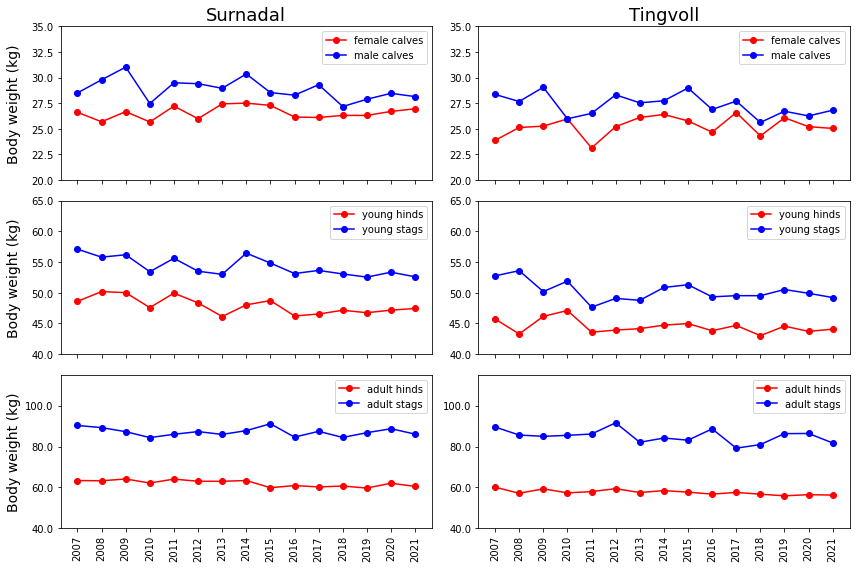

In [4]:
# Plotting
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 8))
years = np.arange(2007,2022,1)

ax[0,0].plot(years,surnadal_female_calves,'ro-')
ax[0,0].plot(years,surnadal_male_calves,'bo-')
ax[0,0].set_ylabel('Body weight (kg)', fontsize=14)
ax[0,0].set_ylim(20,35)
ax[0,0].set_xticks(years)
ax[0,0].set_xticklabels(years, rotation="vertical", fontsize=10)
ax[0,0].set_xticklabels([])
ax[0,0].legend(["female calves", "male calves"],loc="upper right",fontsize=10)
ax[0,0].set_title('Surnadal', fontsize=18)

ax[0,1].plot(years,tingvoll_female_calves,'ro-')
ax[0,1].plot(years,tingvoll_male_calves,'bo-')
#ax[0,1].set_ylabel('Body weight (kg)', fontsize=14)
ax[0,1].set_ylim(20,35)
ax[0,1].set_xticks(years)
ax[0,1].set_xticklabels(years, rotation="vertical", fontsize=10)
ax[0,1].set_xticklabels([])
ax[0,1].legend(["female calves", "male calves"],loc="upper right",fontsize=10)
ax[0,1].set_title('Tingvoll', fontsize=18)

ax[1,0].plot(years,surnadal_young_hinds,'ro-')
ax[1,0].plot(years,surnadal_young_stags,'bo-')
ax[1,0].set_ylabel('Body weight (kg)', fontsize=14)
ax[1,0].set_ylim(40,65)
ax[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1,0].set_xticks(years)
ax[1,0].set_xticklabels([])
ax[1,0].set_xticklabels(years, rotation="vertical", fontsize=10)
ax[1,0].set_xticklabels([])
ax[1,0].legend(["young hinds", "young stags"],loc="upper right",fontsize=10)
#ax[1,0].set_title('Surnadal', fontsize=18)

ax[1,1].plot(years,tingvoll_young_hinds,'ro-')
ax[1,1].plot(years,tingvoll_young_stags,'bo-')
#ax[1,1].set_ylabel('Body weight (kg)', fontsize=14)
ax[1,1].set_ylim(40,65)
ax[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1,1].set_xticks(years)
ax[1,1].set_xticklabels([])
ax[1,1].set_xticklabels(years, rotation="vertical", fontsize=10)
ax[1,1].set_xticklabels([])
ax[1,1].legend(["young hinds", "young stags"],loc="upper right",fontsize=10)

ax[2,0].plot(years,surnadal_adult_hinds,'ro-')
ax[2,0].plot(years,surnadal_adult_stags,'bo-')
ax[2,0].set_ylabel('Body weight (kg)', fontsize=14)
ax[2,0].set_ylim(40,115)
ax[2,0].set_xticks(years)
ax[2,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2,0].set_xticklabels([])
ax[2,0].set_xticklabels(years, rotation="vertical", fontsize=10)
ax[2,0].legend(["adult hinds", "adult stags"],loc="upper right",fontsize=10)

ax[2,1].plot(years,tingvoll_adult_hinds,'ro-')
ax[2,1].plot(years,tingvoll_adult_stags,'bo-')
#ax[2,1].set_ylabel('Body weight (kg)', fontsize=14)
ax[2,1].set_ylim(40,115)
ax[2,1].set_xticks(years)
ax[2,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2,1].set_xticklabels([])
ax[2,1].set_xticklabels(years, rotation="vertical", fontsize=10)
ax[2,1].legend(["adult hinds", "adult stags"],loc="upper right",fontsize=10)

fig.align_ylabels(ax[:, 0])
fig.tight_layout()
save_dir = "figures/"
plt.savefig(save_dir + "Figure_3.pdf", dpi=600, bbox_inches="tight")

pass;